In [368]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import os
import re
import itertools as itr
import matplotlib as mpl
import seaborn as sns
from enm.Enm import Enm
from enm.utils import *
from tqdm import tqdm

In [2]:
with open('../data/interim/pcc.pickle' , 'rb') as f:
    e_pcc = pickle.load(f)

In [3]:
nodes = e_pcc.nodes
n = len(nodes)

In [7]:
effectors_df = pd.read_csv('../data/interim/effectors_df.csv')

In [8]:
sensors_df = pd.read_csv('../data/interim/sensors_df.csv')

In [54]:
sources = effectors_df.loc[effectors_df.effector_cluster==2]
targets = sensors_df.loc[sensors_df.gid==5]

# Find all shortest paths and shortest paths with highest PRS weight

In [460]:
def find_all_shortest_paths(sources, targets, g):
    paths = []
    counts = []
    for s in sources.orf_name.tolist():
        w_track=0
        for t in targets.orf_name.tolist():
            p = list(nx.all_shortest_paths(g, s, t))
#            counts.append(len(p))
#            p_weights = [prs_mat_df.loc[s,pp].sum() for pp in p]
            paths.extend(p)
    #
    shortest_paths = [i for i in paths if len(i) == np.min([len(uu) for uu in paths])]
    #path_weights = [prs_mat_df.loc[pp[0],pp].sum() for pp in shortest_paths]
    return shortest_paths#[np.argmax(path_weights)], counts 
#    return paths

In [336]:
def find_highest_prs_path(sources, targets, g, prs_mat_df):
    paths = []
    counts = []
    for s in sources.orf_name.tolist():
        w_track=0
        for t in targets.orf_name.tolist():
            p = list(nx.all_shortest_paths(g, s, t))
            counts.append(len(p))
            p_weights = [prs_mat_df.loc[s,pp].sum() for pp in p]
            paths.append(p[np.argmax(p_weights)])
    #
    shortest_paths = [i for i in paths if len(i) == np.min([len(uu) for uu in paths])]
    path_weights = [prs_mat_df.loc[pp[0],pp].sum() for pp in shortest_paths]
    return shortest_paths[np.argmax(path_weights)], counts 
#    return paths

In [340]:
all_paths = {0:{} , 1:{}, 2:{}}
all_path_counts ={0:{} , 1:{}, 2:{}}

In [459]:
all_shortest_paths = {0:{},1:{},2:{}}

In [462]:
#counts = []
for i in range(3):
    sources = effectors_df.loc[effectors_df.effector_cluster==i]
    for j in np.arange(1,10):
        targets = sensors_df.loc[sensors_df.gid==j]
        p= find_all_shortest_paths(sources, targets,e_pcc.graph_gc)
        all_shortest_paths[i][j]=p
        #all_path_counts[i][j] = c
        #counts.append(c)

In [502]:
all_shortest_paths_counts = np.zeros((3,10))

In [503]:
for i in range(3):
    for j in range(1,10):
        c = len(all_shortest_paths[i][j])
        all_shortest_paths_counts[i][j] = c

In [508]:
len(all_shortest_paths[0][1])

16

In [510]:
np.set_printoptions(suppress=True)
all_shortest_paths_counts

array([[   0.,   16.,   16., 4089.,    3.,   18.,    1.,    3.,    4.,
          11.],
       [   0.,    3.,  196.,   51.,    6.,   14.,   16.,   11.,   52.,
          44.],
       [   0.,   28.,   16.,   78.,    1.,   40.,   14.,   78.,    1.,
           5.]])

Total shortest paths between effector and sensor clusters

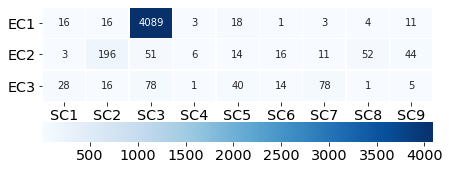

In [618]:
fig, ax = plt.subplots(figsize=(7,2.5))
sns.heatmap(pd.DataFrame(all_shortest_paths_counts[:,1:],index=['EC1','EC2','EC3'],columns=[f"SC{i}" for i in range(1,10)]),
           annot=True, ax = ax, fmt='.0f',linewidths=.5, cmap='Blues',cbar_kws={"orientation": "horizontal"})
plt.yticks(rotation=0) 

fig.savefig('../reports/figures/paper_figures_supp/figs6_a.png',dpi=150, bbox_inches='tight')

<AxesSubplot:>

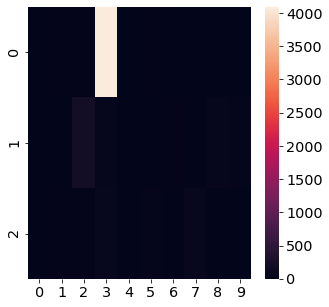

In [590]:
sns.heatmap(all_shortest_paths_counts)

In [516]:
all_shortest_paths_counts.sum()

4815.0

# Calculate GO enrichment of paths using only the genes on the path (excl. effector and sensor)

In [207]:
from gprofiler import GProfiler

In [523]:
gp = GProfiler(return_dataframe=True)
gp_res_ec1 = gp.profile(organism = 'scerevisiae', 
           query = {f"SC{i}":[name_dict[v] for v in val[1:-1]]  for i,val in all_paths[0].items()},
            background = e_pcc.df['Systematic gene name'].tolist(), no_evidences=False, user_threshold=0.1)
gp_res_ec2 = gp.profile(organism = 'scerevisiae', 
           query = {f"SC{i}":[name_dict[v] for v in val[1:-1]]  for i,val in all_paths[1].items()},
            background = e_pcc.df['Systematic gene name'].tolist(), no_evidences=False, user_threshold=0.1)
gp_res_ec3 = gp.profile(organism = 'scerevisiae', 
           query = {f"SC{i}":[name_dict[v] for v in val[1:-1]]  for i,val in all_paths[2].items()},
            background = e_pcc.df['Systematic gene name'].tolist(), no_evidences=False, user_threshold=0.1)

In [525]:
gp_res_ec1.sort_values('query')

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,intersections,evidences
6,GO:MF,GO:0060590,ATPase regulator activity,0.018405,True,"""Binds to and modulates the activity of an ATP...",25,5,2,4658,0.400000,0.080000,SC2,[GO:0060589],"[YPL106C, YNL064C]","[[IDA], [IDA]]"
10,KEGG,KEGG:04141,Protein processing in endoplasmic reticulum,0.036208,True,Protein processing in endoplasmic reticulum,78,5,2,4658,0.400000,0.025641,SC2,[KEGG:00000],"[YPL106C, YNL064C]","[[KEGG], [KEGG]]"
0,WP,WP:WP559,Glutamate degradation VII,0.000201,True,Glutamate degradation VII,6,6,2,4658,0.333333,0.333333,SC3,[WP:000000],"[YDR178W, YLL041C]","[[WP], [WP]]"
1,WP,WP:WP296,TCA Cycle - Detailed,0.001598,True,TCA Cycle - Detailed,16,6,2,4658,0.333333,0.125000,SC3,[WP:000000],"[YDR178W, YLL041C]","[[WP], [WP]]"
2,WP,WP:WP490,TCA Cycle,0.003659,True,TCA Cycle,24,6,2,4658,0.333333,0.083333,SC3,[WP:000000],"[YDR178W, YLL041C]","[[WP], [WP]]"
4,KEGG,KEGG:00020,Citrate cycle (TCA cycle),0.004870,True,Citrate cycle (TCA cycle),24,6,2,4658,0.333333,0.083333,SC3,[KEGG:00000],"[YDR178W, YLL041C]","[[KEGG], [KEGG]]"
7,WP,WP:WP112,Principle Pathways of Carbon Metabolism,0.020763,True,Principle Pathways of Carbon Metabolism,57,6,2,4658,0.333333,0.035088,SC3,[WP:000000],"[YDR178W, YLL041C]","[[WP], [WP]]"
8,KEGG,KEGG:00190,Oxidative phosphorylation,0.022150,True,Oxidative phosphorylation,51,6,2,4658,0.333333,0.039216,SC3,[KEGG:00000],"[YDR178W, YLL041C]","[[KEGG], [KEGG]]"
18,KEGG,KEGG:01200,Carbon metabolism,0.055322,True,Carbon metabolism,81,6,2,4658,0.333333,0.024691,SC3,[KEGG:00000],"[YDR178W, YLL041C]","[[KEGG], [KEGG]]"
27,KEGG,KEGG:00300,Lysine biosynthesis,0.072404,True,Lysine biosynthesis,5,5,1,4658,0.200000,0.200000,SC4,[KEGG:00000],[YGL202W],[[KEGG]]


In [533]:
goea, geneid2name, _ = create_goea()

../data/raw/ontology/go-basic.obo: fmt(1.2) rel(2021-05-01) 47,284 GO Terms; optional_attrs(relationship)
HMS:0:00:01.447728  41,910 annotations READ: ../data/raw/ontology/sgd.gaf BP

Load BP Gene Ontology Analysis ...
Propagating term counts up: is_a and negatively_regulates part_of positively_regulates regulates
 82%  4,782 of  5,813 population items found in association


46 GO IDs NOT FOUND IN ASSOCIATION: GO:0090203 GO:0035961 GO:1990872 GO:1900472 GO:1902353 GO:1900525 GO:0048310 GO:1900466 GO:0090202 GO:1900465 GO:1902352 GO:0061416 GO:0009108 GO:0035955 GO:0061404 GO:1903474 GO:0090579 GO:0034225 GO:1900473 GO:0001324 GO:0061393 GO:1900524 GO:0072363 GO:0035392 GO:0097236 GO:0035952 GO:0061392 GO:0051188 GO:0072321 GO:1900526 GO:0035969 GO:1900008 GO:0000733 GO:1900062 GO:0001300 GO:0061427 GO:1900462 GO:0001302 GO:0010978 GO:0001320 GO:0018065 GO:0018192 GO:0001319 GO:0055114 GO:0071733 GO:0001308


In [534]:
goa_go_dict = {0:{},1:{},2:{}}
for i in range(3):
    #sources = effectors_df.loc[effectors_df.effector_cluster==i]
    for j in np.arange(1,10):
        #targets = sensors_df.loc[sensors_df.gid==j]
        p= all_paths[i][j]
        p_sub = p[1:-1]
        p_sub_df = e_pcc.df.loc[e_pcc.df.orf_name.isin(p_sub)]
        go_res = query_goatools(p_sub_df, goea,geneid2name)
        goa_go_dict[i][j] = go_res
        ##all_shortest_paths[i][j]=p
        
        #all_path_counts[i][j] = c
        #counts.append(c)


Run BP Gene Ontology Analysis: current study set of 3 IDs ...100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     138 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005160846378842216
Sample 10 / 500: p-value 0.0005160846378842216
Sample 20 / 500: p-value 0.0005160846378842216
Sample 30 / 500: p-value 0.0005160846378842216
Sample 40 / 500: p-value 0.0005160846378842216
Sample 50 / 500: p-value 0.003093844546727288
Sample 60 / 500: p-value 0.0010319916829848402
Sample 70 / 500: p-value 0.0005160846378842216
Sample 80 / 500: p-value 0.0025786475671841736
Sample 90 / 500: p-value 0.0008348019556488665
Sample 100 / 500: p-value 0.00034087775581108457
Sample 110 / 500: p-value 0.0005160846378842216
Sample 120 / 500: p-value 0.0020632731170778414
Sample 130 / 500: p-value 0.0012301423245112623
Sample 140 / 500: p-value 0.007209035111138087
Sample 150 / 500: p-value 0.0005160846378842216
Sample 160 / 500: p-value 0.0005160846378842216
Sample 170 / 500: p-value 0.0452395501040469
Sample 180 / 500: p-value 0.004123706216515101
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     170 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005151972850262826
Sample 10 / 500: p-value 0.0004789364823497146
Sample 20 / 500: p-value 0.0017196901503484024
Sample 30 / 500: p-value 0.0017196901503484024
Sample 40 / 500: p-value 0.0008601410631398726
Sample 50 / 500: p-value 0.0017196901503484024
Sample 60 / 500: p-value 0.00429478861182
Sample 70 / 500: p-value 0.0015180391992156393
Sample 80 / 500: p-value 0.0017196901503484024
Sample 90 / 500: p-value 0.0004110260232769493
Sample 100 / 500: p-value 0.004124390337831255
Sample 110 / 500: p-value 0.0008320562334881959
Sample 120 / 500: p-value 0.0017196901503484024
Sample 130 / 500: p-value 0.0017196901503484024
Sample 140 / 500: p-value 0.0034370136192099386
Sample 150 / 500: p-value 0.0017196901503484024
Sample 160 / 500: p-value 0.00027253126012078587
Sample 170 / 500: p-value 0.0008601410631398726
Sample 180 / 500: p-value 0.0008601410631398726
Sample 190 / 500: p-v

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 6 IDs ...100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     169 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001612293097403166
Sample 10 / 500: p-value 0.0010321692757667435
Sample 20 / 500: p-value 0.0030938445467221906
Sample 30 / 500: p-value 0.0020634505876001353
Sample 40 / 500: p-value 0.0010321692757667435
Sample 50 / 500: p-value 0.00024261383025929846
Sample 60 / 500: p-value 0.0010321692757667435
Sample 70 / 500: p-value 0.0020634505876001353
Sample 80 / 500: p-value 0.004123351764069798
Sample 90 / 500: p-value 0.0010321692757667435
Sample 100 / 500: p-value 0.0020634505876001353
Sample 110 / 500: p-value 0.0006468868456476657
Sample 120 / 500: p-value 0.0010321692757667435
Sample 130 / 500: p-value 0.0010321692757667435
Sample 140 / 500: p-value 0.0030938445467221906
Sample 150 / 500: p-value 0.00014075588724010658
Sample 160 / 500: p-value 0.0020634505876001353
Sample 170 / 500: p-value 0.0010321692757667435
Sample 180 / 500: p-value 0.0030938445467221906
Sample 190 / 50

  METHOD fdr:
       4 GO terms found significant (< 0.1=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ... 60%      3 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     158 GO terms are associated with      3 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0034370136192099386
Sample 10 / 500: p-value 0.0008601410631398726
Sample 20 / 500: p-value 0.0017196901503484024
Sample 30 / 500: p-value 0.0017196901503484024
Sample 40 / 500: p-value 0.002005994502304101
Sample 50 / 500: p-value 0.0008601410631398726
Sample 60 / 500: p-value 0.006008566639823969
Sample 70 / 500: p-value 0.0025786475671826905
Sample 80 / 500: p-value 0.006864570285449374
Sample 90 / 500: p-value 0.0008601410631398726
Sample 100 / 500: p-value 0.011988216210660407
Sample 110 / 500: p-value 0.0034370136192099386
Sample 120 / 500: p-value 0.0077199840922887175
Sample 130 / 500: p-value 0.0025786475671826905
Sample 140 / 500: p-value 0.011988216210660407
Sample 150 / 500: p-value 9.007452288629557e-05
Sample 160 / 500: p-value 0.0017196901503484024
Sample 170 / 500: p-value 0.0008601410631398726
Sample 180 / 500: p-value 0.0008601410631398726
Sample 190 / 500: p-

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     199 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008601410631398726
Sample 10 / 500: p-value 0.0008948153275977337
Sample 20 / 500: p-value 1.6541119976256092e-05
Sample 30 / 500: p-value 0.001594395266305337
Sample 40 / 500: p-value 0.0008601410631398726
Sample 50 / 500: p-value 0.006008566639823969
Sample 60 / 500: p-value 0.0008601410631398726
Sample 70 / 500: p-value 0.0017196901503484024
Sample 80 / 500: p-value 0.0008601410631398726
Sample 90 / 500: p-value 0.0017196901503484024
Sample 100 / 500: p-value 0.0008601410631398726
Sample 110 / 500: p-value 2.555275115747202e-05
Sample 120 / 500: p-value 0.00032845552902167186
Sample 130 / 500: p-value 0.0008601410631398726
Sample 140 / 500: p-value 0.006008566639823969
Sample 150 / 500: p-value 0.0017196901503484024
Sample 160 / 500: p-value 0.0008601410631398726
Sample 170 / 500: p-value 0.0008601410631398726
Sample 180 / 500: p-value 0.0008185695304170896
Sample 190 / 500

  METHOD fdr:
       4 GO terms found significant (< 0.1=alpha) (  4 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 3 IDs ... 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     141 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005152858370782808
Sample 10 / 500: p-value 0.0025786475671841736
Sample 20 / 500: p-value 0.0046383709678282856
Sample 30 / 500: p-value 0.0005160846378842216
Sample 40 / 500: p-value 0.0020632731170778414
Sample 50 / 500: p-value 0.0005160846378842216
Sample 60 / 500: p-value 0.0015477211658482314
Sample 70 / 500: p-value 0.003608864086331997
Sample 80 / 500: p-value 0.008680094015567226
Sample 90 / 500: p-value 0.0015477211658482314
Sample 100 / 500: p-value 0.0005160846378842216
Sample 110 / 500: p-value 0.0010319916829848402
Sample 120 / 500: p-value 1
Sample 130 / 500: p-value 0.0010319916829848402
Sample 140 / 500: p-value 0.0020632731170778414
Sample 150 / 500: p-value 0.0010319916829848402
Sample 160 / 500: p-value 0.0010319916829848402
Sample 170 / 500: p-value 0.0010319916829848402
Sample 180 / 500: p-value 0.0046383709678282856
Sample 190 / 500: p-value 0.0036088640

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 4 IDs ...100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      88 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002063273117086419
Sample 10 / 500: p-value 0.004809335334480145
Sample 20 / 500: p-value 0.000688112850515155
Sample 30 / 500: p-value 0.000688112850515155
Sample 40 / 500: p-value 0.000688112850515155
Sample 50 / 500: p-value 0.0013758705154590359
Sample 60 / 500: p-value 0.000688112850515155
Sample 70 / 500: p-value 0.0013758705154590359
Sample 80 / 500: p-value 0.000688112850515155
Sample 90 / 500: p-value 9.931508923640816e-06
Sample 100 / 500: p-value 0.010967251758917078
Sample 110 / 500: p-value 0.005672110704063142
Sample 120 / 500: p-value 0.01777581632677549
Sample 130 / 500: p-value 0.004809335334480145
Sample 140 / 500: p-value 0.0013758705154590359
Sample 150 / 500: p-value 0.0013758705154590359
Sample 160 / 500: p-value 0.013013525801546928
Sample 170 / 500: p-value 0.004123351764093738
Sample 180 / 500: p-value 0.00275032077759516
Sample 190 / 500: p-value 0.000

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     266 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008601410631398726
Sample 10 / 500: p-value 0.006008566639823969
Sample 20 / 500: p-value 0.0008601410631398726
Sample 30 / 500: p-value 0.0017196901503484024
Sample 40 / 500: p-value 0.0025786475671826905
Sample 50 / 500: p-value 0.0004789364823497146
Sample 60 / 500: p-value 0.0008601410631398726
Sample 70 / 500: p-value 0.00017619094693028096
Sample 80 / 500: p-value 0.0025786475671826905
Sample 90 / 500: p-value 0.0025786475671826905
Sample 100 / 500: p-value 0.0025786475671826905
Sample 110 / 500: p-value 0.0008601410631398726
Sample 120 / 500: p-value 0.0025786475671826905
Sample 130 / 500: p-value 0.0004110260232769493
Sample 140 / 500: p-value 0.0017196901503484024
Sample 150 / 500: p-value 0.0008601410631398726
Sample 160 / 500: p-value 0.0008601410631398726
Sample 170 / 500: p-value 0.0017196901503484024
Sample 180 / 500: p-value 0.0017196901503484024
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 6 IDs ... 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     280 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010321692757667435
Sample 10 / 500: p-value 0.0010321692757667435
Sample 20 / 500: p-value 0.0010321692757667435
Sample 30 / 500: p-value 0.0010321692757667435
Sample 40 / 500: p-value 0.0010321692757667435
Sample 50 / 500: p-value 0.0030938445467221906
Sample 60 / 500: p-value 0.0010321692757667435
Sample 70 / 500: p-value 0.0030938445467221906
Sample 80 / 500: p-value 0.0010321692757667435
Sample 90 / 500: p-value 0.011305124765739066
Sample 100 / 500: p-value 0.0010321692757667435
Sample 110 / 500: p-value 0.0004074379920825076
Sample 120 / 500: p-value 0.005151972850257293
Sample 130 / 500: p-value 0.0004606192987494831
Sample 140 / 500: p-value 0.0010321692757667435
Sample 150 / 500: p-value 0.002970717384569411
Sample 160 / 500: p-value 0.0010321692757667435
Sample 170 / 500: p-value 0.0020634505876001353
Sample 180 / 500: p-value 0.0010321692757667435
Sample 190 / 500: 

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 1 IDs ...100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      70 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 1
Sample 10 / 500: p-value 0.0006881128505124145
Sample 20 / 500: p-value 0.00034405642525620723
Sample 30 / 500: p-value 0.07001548253964585
Sample 40 / 500: p-value 0.029244796146779075
Sample 50 / 500: p-value 0.00946155169454581
Sample 60 / 500: p-value 0.006020987441983611
Sample 70 / 500: p-value 0.0017202821262810378
Sample 80 / 500: p-value 0.0006881128505124145
Sample 90 / 500: p-value 1
Sample 100 / 500: p-value 0.0012041974883967254
Sample 110 / 500: p-value 1
Sample 120 / 500: p-value 0.0012041974883967254
Sample 130 / 500: p-value 1
Sample 140 / 500: p-value 1
Sample 150 / 500: p-value 1
Sample 160 / 500: p-value 0.0005160846378843105
Sample 170 / 500: p-value 0.0006881128505124145
Sample 180 / 500: p-value 0.0006881128505124145
Sample 190 / 500: p-value 1
Sample 200 / 500: p-value 0.0018923103389091363
Sample 210 / 500: p-value 0.0006881128505124145
Sample 220 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     193 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008601410631398726
Sample 10 / 500: p-value 0.0008601410631398726
Sample 20 / 500: p-value 0.0015596666831273515
Sample 30 / 500: p-value 0.0008601410631398726
Sample 40 / 500: p-value 0.0008601410631398726
Sample 50 / 500: p-value 0.0025786475671826905
Sample 60 / 500: p-value 0.0008601410631398726
Sample 70 / 500: p-value 0.0017196901503484024
Sample 80 / 500: p-value 0.0034370136192099386
Sample 90 / 500: p-value 0.0017196901503484024
Sample 100 / 500: p-value 0.0008601410631398726
Sample 110 / 500: p-value 0.0077451008256480235
Sample 120 / 500: p-value 0.0025786475671826905
Sample 130 / 500: p-value 0.00429478861182
Sample 140 / 500: p-value 0.0008601410631398726
Sample 150 / 500: p-value 0.00429478861182
Sample 160 / 500: p-value 0.0017196901503484024
Sample 170 / 500: p-value 0.0007723235020155041
Sample 180 / 500: p-value 0.00429478861182
Sample 190 / 500: p-value 0.00

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      83 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017196901503484024
Sample 10 / 500: p-value 0.0008601410631398726
Sample 20 / 500: p-value 0.023016917223038114
Sample 30 / 500: p-value 0.0025786475671826905
Sample 40 / 500: p-value 0.0025786475671826905
Sample 50 / 500: p-value 7.139929949834783e-05
Sample 60 / 500: p-value 0.0008601410631398726
Sample 70 / 500: p-value 0.0008601410631398726
Sample 80 / 500: p-value 0.0025786475671826905
Sample 90 / 500: p-value 0.0017196901503484024
Sample 100 / 500: p-value 0.0034370136192099386
Sample 110 / 500: p-value 0.0008601410631398726
Sample 120 / 500: p-value 0.0025786475671826905
Sample 130 / 500: p-value 0.0008601410631398726
Sample 140 / 500: p-value 0.0008601410631398726
Sample 150 / 500: p-value 0.0037316575159075834
Sample 160 / 500: p-value 0.0008601410631398726
Sample 170 / 500: p-value 0.0008601410631398726
Sample 180 / 500: p-value 0.00429478861182
Sample 190 / 500: p-v

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      95 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017196901503484024
Sample 10 / 500: p-value 0.000702845695444663
Sample 20 / 500: p-value 0.0008601410631398726
Sample 30 / 500: p-value 0.0017196901503484024
Sample 40 / 500: p-value 0.0017196901503484024
Sample 50 / 500: p-value 0.0008601410631398726
Sample 60 / 500: p-value 0.006864570285449374
Sample 70 / 500: p-value 0.00027253126012078587
Sample 80 / 500: p-value 0.0008601410631398726
Sample 90 / 500: p-value 0.0025786475671826905
Sample 100 / 500: p-value 0.0017196901503484024
Sample 110 / 500: p-value 0.0017196901503484024
Sample 120 / 500: p-value 0.0003869291490423587
Sample 130 / 500: p-value 0.0025786475671826905
Sample 140 / 500: p-value 0.0025786475671826905
Sample 150 / 500: p-value 0.0008601410631398726
Sample 160 / 500: p-value 0.001820922807193052
Sample 170 / 500: p-value 0.00429478861182
Sample 180 / 500: p-value 0.0008601410631398726
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      46 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0025786475671826905
Sample 10 / 500: p-value 0.0008601410631398726
Sample 20 / 500: p-value 0.0008601410631398726
Sample 30 / 500: p-value 0.0008601410631398726
Sample 40 / 500: p-value 0.021326635376274532
Sample 50 / 500: p-value 0.0034370136192099386
Sample 60 / 500: p-value 0.00035369988235310986
Sample 70 / 500: p-value 0.0008601410631398726
Sample 80 / 500: p-value 0.0034370136192099386
Sample 90 / 500: p-value 0.0009931436728764186
Sample 100 / 500: p-value 0.0034370136192099386
Sample 110 / 500: p-value 0.0034370136192099386
Sample 120 / 500: p-value 0.0008601410631398726
Sample 130 / 500: p-value 0.0017196901503484024
Sample 140 / 500: p-value 0.0017196901503484024
Sample 150 / 500: p-value 0.0008601410631398726
Sample 160 / 500: p-value 0.0008601410631398726
Sample 170 / 500: p-value 0.0034370136192099386
Sample 180 / 500: p-value 0.0025595698416703743
Sample 190 / 50

  METHOD fdr:
      13 GO terms found significant (< 0.1=alpha) ( 13 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 3 IDs ... 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     105 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005160846378842216
Sample 10 / 500: p-value 0.0005160846378842216
Sample 20 / 500: p-value 0.014383339906768208
Sample 30 / 500: p-value 0.0005160846378842216
Sample 40 / 500: p-value 0.0015477211658482314
Sample 50 / 500: p-value 0.0005160846378842216
Sample 60 / 500: p-value 1.1707676862982888e-05
Sample 70 / 500: p-value 0.0014672481622891936
Sample 80 / 500: p-value 0.003608864086331997
Sample 90 / 500: p-value 0.0005160846378842216
Sample 100 / 500: p-value 0.0005160846378842216
Sample 110 / 500: p-value 0.003093844546727288
Sample 120 / 500: p-value 0.0005160846378842216
Sample 130 / 500: p-value 0.005152858370782808
Sample 140 / 500: p-value 0.003608864086331997
Sample 150 / 500: p-value 0.0010319916829848402
Sample 160 / 500: p-value 0.003093844546727288
Sample 170 / 500: p-value 0.0015477211658482314
Sample 180 / 500: p-value 0.0015477211658482314
Sample 190 / 500: p-

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 4 IDs ...100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      87 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005494964452411158
Sample 10 / 500: p-value 0.00275032077759516
Sample 20 / 500: p-value 0.0034370136192262003
Sample 30 / 500: p-value 0.004123351764093738
Sample 40 / 500: p-value 0.000688112850515155
Sample 50 / 500: p-value 0.000688112850515155
Sample 60 / 500: p-value 0.00016406428669202045
Sample 70 / 500: p-value 0.000688112850515155
Sample 80 / 500: p-value 0.0013758705154590359
Sample 90 / 500: p-value 0.000688112850515155
Sample 100 / 500: p-value 0.000688112850515155
Sample 110 / 500: p-value 0.005494964452411158
Sample 120 / 500: p-value 0.0034370136192262003
Sample 130 / 500: p-value 0.00275032077759516
Sample 140 / 500: p-value 0.006865159819426489
Sample 150 / 500: p-value 0.0034370136192262003
Sample 160 / 500: p-value 0.000688112850515155
Sample 170 / 500: p-value 0.0003820664450832272
Sample 180 / 500: p-value 0.00044970568009749997
Sample 190 / 500: p-value 0

  METHOD fdr:
       4 GO terms found significant (< 0.1=alpha) (  4 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ... 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     197 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008601410631398726
Sample 10 / 500: p-value 0.0008601410631398726
Sample 20 / 500: p-value 0.0017196901503484024
Sample 30 / 500: p-value 0.0017196901503484024
Sample 40 / 500: p-value 0.008114663114978406
Sample 50 / 500: p-value 0.00019080770188725467
Sample 60 / 500: p-value 0.0007132629746865087
Sample 70 / 500: p-value 0.0025786475671826905
Sample 80 / 500: p-value 0.0017196901503484024
Sample 90 / 500: p-value 0.0025786475671826905
Sample 100 / 500: p-value 0.0008601410631398726
Sample 110 / 500: p-value 0.0008601410631398726
Sample 120 / 500: p-value 0.0008601410631398726
Sample 130 / 500: p-value 0.0008601410631398726
Sample 140 / 500: p-value 0.006008566639823969
Sample 150 / 500: p-value 0.010282689527855953
Sample 160 / 500: p-value 0.0017196901503484024
Sample 170 / 500: p-value 8.748013316585055e-05
Sample 180 / 500: p-value 0.0008601410631398726
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ... 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     122 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 9.007452288629557e-05
Sample 10 / 500: p-value 0.0008601410631398726
Sample 20 / 500: p-value 0.0025786475671826905
Sample 30 / 500: p-value 0.0017196901503484024
Sample 40 / 500: p-value 0.006008566639823969
Sample 50 / 500: p-value 0.0034370136192099386
Sample 60 / 500: p-value 0.0008601410631398726
Sample 70 / 500: p-value 0.0017196901503484024
Sample 80 / 500: p-value 0.0008601410631398726
Sample 90 / 500: p-value 0.0008601410631398726
Sample 100 / 500: p-value 0.0077199840922887175
Sample 110 / 500: p-value 0.00429478861182
Sample 120 / 500: p-value 0.005151972850262826
Sample 130 / 500: p-value 0.0010614821129953623
Sample 140 / 500: p-value 0.018786826821398143
Sample 150 / 500: p-value 0.0004330940722396832
Sample 160 / 500: p-value 0.0008601410631398726
Sample 170 / 500: p-value 0.0008601410631398726
Sample 180 / 500: p-value 5.3647640110519863e-05
Sample 190 / 500: p-va

  METHOD fdr:
      15 GO terms found significant (< 0.1=alpha) ( 15 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 3 IDs ...100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     123 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0020632731170778414
Sample 10 / 500: p-value 0.0010319916829848402
Sample 20 / 500: p-value 0.0005160846378842216
Sample 30 / 500: p-value 0.008749307006844866
Sample 40 / 500: p-value 0.0015477211658482314
Sample 50 / 500: p-value 7.700470291999264e-05
Sample 60 / 500: p-value 0.0005160846378842216
Sample 70 / 500: p-value 0.0015477211658482314
Sample 80 / 500: p-value 0.0010319916829848402
Sample 90 / 500: p-value 0.0015477211658482314
Sample 100 / 500: p-value 0.0010319916829848402
Sample 110 / 500: p-value 0.003608864086331997
Sample 120 / 500: p-value 0.0014226082548675456
Sample 130 / 500: p-value 0.0025786475671841736
Sample 140 / 500: p-value 0.003608864086331997
Sample 150 / 500: p-value 0.0046383709678282856
Sample 160 / 500: p-value 0.0005160846378842216
Sample 170 / 500: p-value 0.0005160846378842216
Sample 180 / 500: p-value 0.0005160846378842216
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 4 IDs ...100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     208 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002063273117086419
Sample 10 / 500: p-value 3.549411129054501e-06
Sample 20 / 500: p-value 0.0025915420394876103
Sample 30 / 500: p-value 0.00275032077759516
Sample 40 / 500: p-value 0.002063273117086419
Sample 50 / 500: p-value 0.002063273117086419
Sample 60 / 500: p-value 0.000688112850515155
Sample 70 / 500: p-value 0.0034370136192262003
Sample 80 / 500: p-value 0.0013758705154590359
Sample 90 / 500: p-value 0.000688112850515155
Sample 100 / 500: p-value 0.000688112850515155
Sample 110 / 500: p-value 0.000688112850515155
Sample 120 / 500: p-value 0.000688112850515155
Sample 130 / 500: p-value 0.002063273117086419
Sample 140 / 500: p-value 0.0015833209445775874
Sample 150 / 500: p-value 0.002063273117086419
Sample 160 / 500: p-value 0.002063273117086419
Sample 170 / 500: p-value 0.000688112850515155
Sample 180 / 500: p-value 0.002063273117086419
Sample 190 / 500: p-value 0.00

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 3 IDs ...100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      97 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005160846378842216
Sample 10 / 500: p-value 0.0005160846378842216
Sample 20 / 500: p-value 0.0005160846378842216
Sample 30 / 500: p-value 0.05322495941928765
Sample 40 / 500: p-value 0.021624764843346234
Sample 50 / 500: p-value 0.0010319916829848402
Sample 60 / 500: p-value 0.0025786475671841736
Sample 70 / 500: p-value 0.0009220852498519628
Sample 80 / 500: p-value 0.0005160846378842216
Sample 90 / 500: p-value 0.0005160846378842216
Sample 100 / 500: p-value 0.015405410353951135
Sample 110 / 500: p-value 0.005152858370782808
Sample 120 / 500: p-value 0.0015477211658482314
Sample 130 / 500: p-value 0.0010319916829848402
Sample 140 / 500: p-value 0.0015477211658482314
Sample 150 / 500: p-value 0.010287984968240805
Sample 160 / 500: p-value 0.0046383709678282856
Sample 170 / 500: p-value 0.0005160846378842216
Sample 180 / 500: p-value 0.0005160846378842216
Sample 190 / 500: p-v

  METHOD fdr:
       7 GO terms found significant (< 0.1=alpha) (  7 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 4 IDs ... 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      35 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000688112850515155
Sample 10 / 500: p-value 0.000688112850515155
Sample 20 / 500: p-value 0.0015726415327788675
Sample 30 / 500: p-value 0.012331787604828753
Sample 40 / 500: p-value 0.000688112850515155
Sample 50 / 500: p-value 0.004809335334480145
Sample 60 / 500: p-value 0.004738810596957521
Sample 70 / 500: p-value 0.000688112850515155
Sample 80 / 500: p-value 0.004123351764093738
Sample 90 / 500: p-value 0.0015849229027880966
Sample 100 / 500: p-value 0.0013758705154590359
Sample 110 / 500: p-value 0.0013758705154590359
Sample 120 / 500: p-value 0.0013758705154590359
Sample 130 / 500: p-value 0.002063273117086419
Sample 140 / 500: p-value 0.000688112850515155
Sample 150 / 500: p-value 0.000688112850515155
Sample 160 / 500: p-value 0.0004655898882767832
Sample 170 / 500: p-value 0.0034370136192262003
Sample 180 / 500: p-value 0.004123351764093738
Sample 190 / 500: p-value 0

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     104 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006008566639823969
Sample 10 / 500: p-value 0.0025786475671826905
Sample 20 / 500: p-value 0.002402131423015291
Sample 30 / 500: p-value 0.0025786475671826905
Sample 40 / 500: p-value 0.0025786475671826905
Sample 50 / 500: p-value 0.00010063682925604525
Sample 60 / 500: p-value 0.0008601410631398726
Sample 70 / 500: p-value 0.0017196901503484024
Sample 80 / 500: p-value 0.0008601410631398726
Sample 90 / 500: p-value 0.0008601410631398726
Sample 100 / 500: p-value 0.0017196901503484024
Sample 110 / 500: p-value 0.0025786475671826905
Sample 120 / 500: p-value 0.0017196901503484024
Sample 130 / 500: p-value 0.0008601410631398726
Sample 140 / 500: p-value 0.0008601410631398726
Sample 150 / 500: p-value 0.0025786475671826905
Sample 160 / 500: p-value 0.0008601410631398726
Sample 170 / 500: p-value 0.0006034680504779716
Sample 180 / 500: p-value 0.0008601410631398726
Sample 190 / 500

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 3 IDs ... 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      55 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010319916829848402
Sample 10 / 500: p-value 0.0005160846378842216
Sample 20 / 500: p-value 0.05620796983818667
Sample 30 / 500: p-value 0.0005160846378842216
Sample 40 / 500: p-value 0.0005160846378842216
Sample 50 / 500: p-value 0.0005160846378842216
Sample 60 / 500: p-value 0.0010319916829848402
Sample 70 / 500: p-value 0.0010319916829848402
Sample 80 / 500: p-value 0.0020632731170778414
Sample 90 / 500: p-value 0.0005160846378842216
Sample 100 / 500: p-value 0.00669525679570547
Sample 110 / 500: p-value 0.003608864086331997
Sample 120 / 500: p-value 0.05620796983818667
Sample 130 / 500: p-value 0.013360562389188795
Sample 140 / 500: p-value 0.0061813012542468425
Sample 150 / 500: p-value 0.003093844546727288
Sample 160 / 500: p-value 0.0015477211658482314
Sample 170 / 500: p-value 0.00202927511584895
Sample 180 / 500: p-value 1
Sample 190 / 500: p-value 0.000516084637884221

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     124 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00024793265104438005
Sample 10 / 500: p-value 0.0008601410631398726
Sample 20 / 500: p-value 0.010282689527855953
Sample 30 / 500: p-value 0.0025786475671826905
Sample 40 / 500: p-value 0.0008601410631398726
Sample 50 / 500: p-value 0.0017196901503484024
Sample 60 / 500: p-value 0.0002905997093111164
Sample 70 / 500: p-value 0.00020600124658035757
Sample 80 / 500: p-value 0.006864570285449374
Sample 90 / 500: p-value 0.00036859923553608434
Sample 100 / 500: p-value 0.0008601410631398726
Sample 110 / 500: p-value 0.0008601410631398726
Sample 120 / 500: p-value 0.0015072175199066248
Sample 130 / 500: p-value 0.0008601410631398726
Sample 140 / 500: p-value 0.0008601410631398726
Sample 150 / 500: p-value 0.0034370136192099386
Sample 160 / 500: p-value 0.0017196901503484024
Sample 170 / 500: p-value 0.0008601410631398726
Sample 180 / 500: p-value 0.005151972850262826
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 4 IDs ... 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     154 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002063273117086419
Sample 10 / 500: p-value 0.000688112850515155
Sample 20 / 500: p-value 0.000688112850515155
Sample 30 / 500: p-value 0.0013758705154590359
Sample 40 / 500: p-value 0.00275032077759516
Sample 50 / 500: p-value 0.000688112850515155
Sample 60 / 500: p-value 0.002063273117086419
Sample 70 / 500: p-value 0.002063273117086419
Sample 80 / 500: p-value 0.0013758705154590359
Sample 90 / 500: p-value 0.002063273117086419
Sample 100 / 500: p-value 0.0005210578598692035
Sample 110 / 500: p-value 0.000688112850515155
Sample 120 / 500: p-value 0.0034370136192262003
Sample 130 / 500: p-value 0.002063273117086419
Sample 140 / 500: p-value 0.000688112850515155
Sample 150 / 500: p-value 0.002063273117086419
Sample 160 / 500: p-value 1.390545442090736e-07
Sample 170 / 500: p-value 0.0034965145229892388
Sample 180 / 500: p-value 0.002063273117086419
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 4 IDs ... 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      93 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002063273117086419
Sample 10 / 500: p-value 0.000688112850515155
Sample 20 / 500: p-value 0.00275032077759516
Sample 30 / 500: p-value 0.01845473402782502
Sample 40 / 500: p-value 0.002063273117086419
Sample 50 / 500: p-value 0.004907681684253444
Sample 60 / 500: p-value 0.000688112850515155
Sample 70 / 500: p-value 0.000688112850515155
Sample 80 / 500: p-value 0.00275032077759516
Sample 90 / 500: p-value 6.720684399737854e-05
Sample 100 / 500: p-value 0.000688112850515155
Sample 110 / 500: p-value 0.000688112850515155
Sample 120 / 500: p-value 0.0013758705154590359
Sample 130 / 500: p-value 0.000688112850515155
Sample 140 / 500: p-value 0.000688112850515155
Sample 150 / 500: p-value 0.0013758705154590359
Sample 160 / 500: p-value 0.006180239239995949
Sample 170 / 500: p-value 0.000688112850515155
Sample 180 / 500: p-value 0.000688112850515155
Sample 190 / 500: p-value 0.002063

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


There are 12 paths with no GO enrichments

In [555]:
len([val_sub for key, val in goa_go_dict.items() for _, val_sub in val.items() if val_sub is None])

12

In [589]:
goa_go_dict[2][2].name.tolist()

['positive regulation of phosphatidylcholine metabolic process',
 'positive regulation of phosphatidylcholine biosynthetic process']

In [511]:
all_shortest_paths[2][4]

[['coa2', 'cto1', 'ycr102w-a', 'cst26', 'hpf1', 'ycr062w']]

In [512]:
all_shortest_paths[2][8]

[['mss2', 'glo1', 'ymr122w-a', 'jjj3', 'edc2', 'inm1']]

In [514]:
path_go_dict['coa2']['ycr062w']

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,intersections,evidences


In [489]:
pd.DataFrame(path_go_dict['elg1']['fum1'].intersections.to_list(), columns = ['c1', 'c2', 'c3','c4','c5']).drop_duplicates()

,c1,c2,c3,c4,c5
0,sdh1,sdh2,fum1,None,None
12,sdh4,sdh2,fum1,None,None
140,sdh1,sdh2,None,None,None
187,atp14,sdh1,sdh2,None,None
256,coq1,sdh4,sdh2,fum1,None
257,coq1,sdh1,sdh2,fum1,None
296,sdh2,fum1,None,None,None
319,pcl8,hap2,sdh4,sdh2,fum1
563,shy1,sdh2,fum1,None,None
587,coq1,sdh2,fum1,None,None


In [ ]:
path_go_dict['elg1']['fum1'].loc[path_go_dict['elg1']['fum1']['query']=='34']

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,intersections,evidences
30,WP,WP:WP559,Glutamate degradation VII,3.458671e-07,True,Glutamate degradation VII,6,7,3,4658,0.428571,0.500000,34,[WP:000000],"[sdh4, sdh2, fum1]","[[WP], [WP], [WP]]"
65,WP,WP:WP296,TCA Cycle - Detailed,9.621989e-06,True,TCA Cycle - Detailed,16,7,3,4658,0.428571,0.187500,34,[WP:000000],"[sdh4, sdh2, fum1]","[[WP], [WP], [WP]]"
118,WP,WP:WP490,TCA Cycle,3.459734e-05,True,TCA Cycle,24,7,3,4658,0.428571,0.125000,34,[WP:000000],"[sdh4, sdh2, fum1]","[[WP], [WP], [WP]]"
136,KEGG,KEGG:00020,Citrate cycle (TCA cycle),4.602750e-05,True,Citrate cycle (TCA cycle),24,7,3,4658,0.428571,0.125000,34,[KEGG:00000],"[sdh4, sdh2, fum1]","[[KEGG], [KEGG], [KEGG]]"
216,WP,WP:WP112,Principle Pathways of Carbon Metabolism,4.895793e-04,True,Principle Pathways of Carbon Metabolism,57,7,3,4658,0.428571,0.052632,34,[WP:000000],"[sdh4, sdh2, fum1]","[[WP], [WP], [WP]]"
292,KEGG,KEGG:01200,Carbon metabolism,1.869811e-03,True,Carbon metabolism,81,7,3,4658,0.428571,0.037037,34,[KEGG:00000],"[sdh4, sdh2, fum1]","[[KEGG], [KEGG], [KEGG]]"
338,HP,HP:0100751,Esophageal neoplasm,1.207509e-02,True,A tumor (abnormal growth of tissue) of the eso...,5,7,2,4658,0.285714,0.400000,34,"[HP:0002031, HP:0007378, HP:0012288]","[sdh2, fum1]","[[HP], [HP]]"
840,KEGG,KEGG:00190,Oxidative phosphorylation,2.642291e-02,True,Oxidative phosphorylation,51,7,2,4658,0.285714,0.039216,34,[KEGG:00000],"[sdh4, sdh2]","[[KEGG], [KEGG]]"
1031,HP,HP:0002864,Paraganglioma of head and neck,3.373767e-02,True,Paraganglioma of head and neck,8,7,2,4658,0.285714,0.250000,34,[HP:0002668],"[sdh2, fum1]","[[HP], [HP]]"
1032,HP,HP:0003345,Elevated urinary norepinephrine,3.373767e-02,True,An increased concentration of noradrenaline in...,8,7,2,4658,0.285714,0.250000,34,[HP:0011976],"[sdh2, fum1]","[[HP], [HP]]"


In [493]:
[itr for itr, i in enumerate(paths_dict['elg1']['fum1']) if i == all_paths[0][3]]

[34]

In [472]:
all_paths[0][3]

['elg1', 'cdc9-5002', 'avt1', 'aep1', 'hap2', 'sdh4', 'sdh2', 'fum1']

In [466]:
[len(i) for i in all_shortest_paths[0].values()]

[16, 16, 4089, 3, 18, 1, 3, 4, 11]

In [341]:
counts = []
for i in range(3):
    sources = effectors_df.loc[effectors_df.effector_cluster==i]
    for j in np.arange(1,10):
        targets = sensors_df.loc[sensors_df.gid==j]
        p,c = find_highest_prs_path(sources, targets,e_pcc.graph_gc, e_pcc.prs_mat_df)
        all_paths[i][j]=p
        all_path_counts[i][j] = c
        #counts.append(c)

In [111]:
sensor_colors = [mpl.colors.to_hex(i) for i in sns.color_palette('Set3')]
effector_colors = ["#A65628", "#F781BF", "#999999",'blue','yellow','red']


In [175]:
name_dict = e_pcc.df.loc[:,['orf_name','Systematic gene name']].set_index('orf_name').to_dict()['Systematic gene name']

In [166]:
all_paths

{0: {1: ['mrc1', 'mcm4-5001', 'yat2', 'mob2-22', 'mob2-19'],
  2: ['mad2', 'gim5', 'rpl37a', 'rpl42b', 'sse1', 'ydj1', 'hsc82'],
  3: ['elg1', 'cdc9-5002', 'avt1', 'aep1', 'hap2', 'sdh4', 'sdh2', 'fum1'],
  4: ['bim1', 'clb4', 'ynl097c-b', 'apt1', 'aro8', 'yer046w-a', 'sip4'],
  5: ['mrc1', 'rad9', 'sbh2', 'sfc1', 'sit1', 'ftr1', 'fet3'],
  6: ['ctf4', 'hhf1', 'hht1', 'ydl159w-a', 'rtg1'],
  7: ['hrp1-4', 'pex1', 'tvp18', 'ubc6', 'yet2', 'sps18'],
  8: ['hrp1-4', 'dbf4-2', 'cwc2-1', 'nop1-3', 'jjj3', 'edc2', 'inm1'],
  9: ['mad2',
   'shp1',
   'abf1-102-supp1',
   'oar1',
   'lpd1-supp1',
   'hom3',
   'ydr157w',
   'bap2']},
 1: {1: ['arl3', 'mob2-11', 'mob2-14', 'mob2-34'],
  2: ['cog5', 'cbf1', 'cdc50', 'rpl42b', 'sse1', 'ydj1', 'hsc82'],
  3: ['cop1-1', 'ent5', 'ycf1', 'ecm29', 'sdh1', 'sdh2', 'fbp1'],
  4: ['ost3', 'chs2-5006', 'ydl206w', 'tae1', 'cst26', 'hpf1', 'ycr062w'],
  5: ['cog6', 'pkr1', 'tvp18', 'fit3', 'sit1', 'ftr1', 'fet3'],
  6: ['gab1-1', 'arv1', 'ecm31', 'ydl159w-

In [159]:
effectors_df['cluster']=['EC'+str(i+1) for i in effectors_df['effector_cluster'].tolist()]
effectors_df['is_effector']=True

In [140]:
sensors_df['cluster']=['SC'+str(i) for i in sensors_df['gid'].tolist()]
sensors_df['is_sensor']=True

In [141]:
pd.concat([effectors_df,sensors_df]).to_csv('../data/interim/eff_sens_combined_for_coloring.csv',index=False)

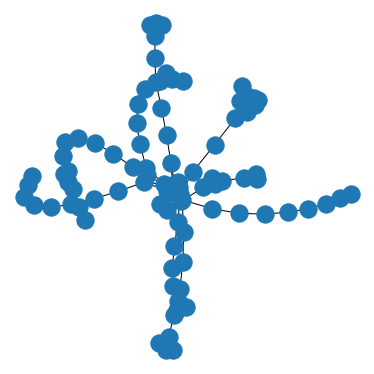

In [133]:
node_list = [*effectors_df.loc[effectors_df.effector_cluster==0].orf_name.tolist(), 
             *sensors_df.loc[sensors_df.gid!=0].orf_name.tolist(),
             *[item for sublist in [v for key,v in all_paths[0].items()] for item in sublist]]

node_sub = nx.induced_subgraph(e_pcc.graph_gc, node_list)

nx.draw(node_sub)
nx.write_edgelist(nx.induced_subgraph(e_pcc.graph_gc,node_list),f'../data/interim/eff_sens_path0.csv', delimiter=',',data=False)

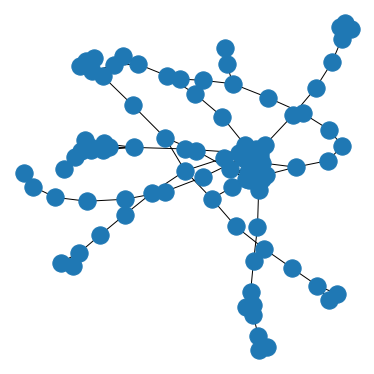

In [134]:
node_list = [*effectors_df.loc[effectors_df.effector_cluster==1].orf_name.tolist(), 
             *sensors_df.loc[sensors_df.gid!=0].orf_name.tolist(),
             *[item for sublist in [v for key,v in all_paths[1].items()] for item in sublist]]

node_sub = nx.induced_subgraph(e_pcc.graph_gc, node_list)

nx.draw(node_sub)
nx.write_edgelist(nx.induced_subgraph(e_pcc.graph_gc,node_list),f'../data/interim/eff_sens_path1.csv', delimiter=',',data=False)

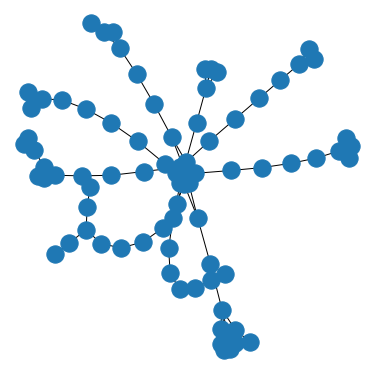

In [135]:
node_list = [*effectors_df.loc[effectors_df.effector_cluster==2].orf_name.tolist(), 
             *sensors_df.loc[sensors_df.gid!=0].orf_name.tolist(),
             *[item for sublist in [v for key,v in all_paths[2].items()] for item in sublist]]

node_sub = nx.induced_subgraph(e_pcc.graph_gc, node_list)

nx.draw(node_sub)
nx.write_edgelist(nx.induced_subgraph(e_pcc.graph_gc,node_list),f'../data/interim/eff_sens_path2.csv', delimiter=',',data=False)

In [107]:
pos = e_pcc.graph_gc.nodes('pos')

In [160]:
sensor_color_map = dict(zip(sensors_df.cluster.sort_values().unique()[1:10],sensor_colors[1:10]))
effector_color_map = dict(zip(effectors_df.cluster.sort_values().unique(),effector_colors[:3]))

In [619]:
sensor_legend_elements = [Line2D([0], [0], marker='^', color='black', label=label,
                              markerfacecolor=color, markersize=10, linestyle="None") for label,color in sensor_color_map.items()] 
effector_legend_elements = [Line2D([0], [0], marker='s', color='black', label=label,
                              markerfacecolor=color, markersize=10, linestyle="None") for label,color in effector_color_map.items()] 

In [620]:
legend_elements = [*effector_legend_elements, 
                   *sensor_legend_elements,
                   *[Line2D([0], [0], marker='o', color='black', label='Other Genes',
                              markerfacecolor='black', markersize=10, linestyle="None"),
                     Line2D([0], [0], marker='o', color='black', label= 'PCC ≥ 0.2',
                              markerfacecolor='black', markersize=0, linestyle="-", alpha=0.5, lw=5)
                    ]]

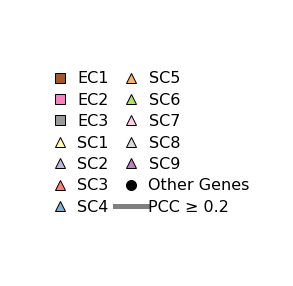

<Figure size 216x72 with 0 Axes>

In [627]:
fig = plt.figure()
figlegend = plt.figure(figsize=(3,1))
ax = fig.add_subplot(111)
#lines = ax.plot(range(10), plt.randn(10), range(10), plt.randn(10))
ax.axis('off')
lgd = ax.legend(handles=legend_elements,
                handletextpad=0.1, 
                labelspacing=0.4, 
                borderpad=0,
                columnspacing=0.4,
                fontsize=16, 
                ncol=2,
                frameon=False, 
                loc = 'center',
                bbox_to_anchor=(0., 0., 1, 1))
#if snakemake.params['save']:
#fig.savefig(f'../reports/figures/paper_figures_supp/figs6_legend.pdf', dpi=150, pad_inches=0)#, bbox_inches='tight')

NameError: name 'sensor_order' is not defined

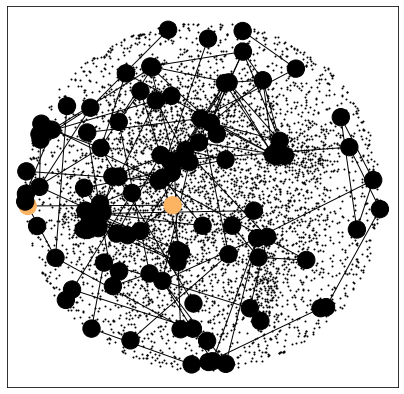

In [112]:
#if plot_paths:
eff_group = 'Respiratory complex assembly'
sens_group = 'SC5\nIron ion\ntransport'
node_list = [*effectors_df.loc[effectors_df.effector_cluster==0].orf_name.tolist(), 
             *sensors_df.orf_name.tolist(),
             *[item for sublist in [v for key,v in all_paths[0].items()] for item in sublist]]

node_sub = nx.induced_subgraph(e_pcc.graph_gc, node_list)
#node_sub=nx.induced_subgraph(sub,[i for i in l1 if i !=target])
#print(l1)
fig, ax = plt.subplots(figsize=(7,7))
legend_elements = [    ]
nx.draw_networkx_nodes(e_pcc.graph_gc, pos=pos, node_size=1, ax=ax, node_color='black')
nx.draw_networkx_nodes(node_sub,pos=pos,alpha=1,
                    #  node_size = [prs_mat_df.loc[source,:].to_dict()[i]*10000 for i in sub.nodes],
                    # node_shape = ['^' if i == target else 'o' for i in sub.nodes],
    node_color = [sensor_colors[5]  if i in ['sit1','ftr1'] else 'black' for i in node_sub.nodes])
nx.draw_networkx_edges(sub,pos=pos)
for itr, i in enumerate(sensor_order):
    #print(i, effector_colors[itr])
    if i ==sens_group:
        orf_names_to_plot = sensors_pcc.loc[sensors_pcc.label==i, 'orf_name'].tolist()
        sub_list.extend(orf_names_to_plot)
        nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
                            node_color=sensor_colors[itr],
                            node_shape='^',edgecolors='black',
                            linewidths=1)
        nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, orf_names_to_plot), ax=ax , pos=pos, edge_color='red',alpha=0.5)

        legend_elements.append(
            Line2D([0], [0], marker='^', color='black', label=f'Sensors ({i})',
                                markerfacecolor=sensor_colors[itr], markersize=12, linestyle="None")
        )

for itr, i in enumerate(effector_order):
    if i == eff_group:
        orf_names_to_plot = effector_pcc.loc[effector_pcc.go_group==i,'orf_name'].tolist()
        sub_list.extend(orf_names_to_plot)
        nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
                            node_color=effector_colors[itr],
                            node_shape='s',edgecolors='black',
                            linewidths=1)
        nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, orf_names_to_plot), ax=ax , pos=pos, edge_color='blue',alpha=0.5)

ax.set_facecolor('white')
ax.axis('off')

# if snakemake.params['save']:
#     plt.savefig(f'{figure_folder}/fig5f.png',bbox_inches='tight',dpi=150)
# nx.write_edgelist(nx.induced_subgraph(e_pcc.graph_gc,sub_list),f'{figure_folder}/path2.csv', delimiter=',',data=False)

In [217]:
([print(name_dict[i]) for i in all_paths[2][9]])

YLR091W
YLR239C
YFL018C
YER052C
YDR157W
YBR068C


[None, None, None, None, None, None]

In [207]:
from gprofiler import GProfiler

In [223]:
[name_dict[i] for i in all_paths[2][9]][1:-1]

['YLR239C', 'YFL018C', 'YER052C', 'YDR157W']

In [226]:
gp = GProfiler(return_dataframe=True)
gp_res = gp.profile(organism = 'scerevisiae', 
           query = [name_dict[i] for i in all_paths[2][9]][1:])

In [301]:
gp = GProfiler(return_dataframe=True)
gp_res0 = gp.profile(organism = 'scerevisiae', 
           query = {f"query{i}":[name_dict[v] for v in val[1:-1]]  for i,val in all_paths[0].items()},
            background = e_pcc.df['Systematic gene name'].tolist(), no_evidences=False)
gp_res1 = gp.profile(organism = 'scerevisiae', 
           query = {f"query{i}":[name_dict[v] for v in val[1:-1]]  for i,val in all_paths[1].items()},
            background = e_pcc.df['Systematic gene name'].tolist(), no_evidences=False)
gp_res2 = gp.profile(organism = 'scerevisiae', 
           query = {f"query{i}":[name_dict[v] for v in val[1:-1]]  for i,val in all_paths[2].items()},
            background = e_pcc.df['Systematic gene name'].tolist(), no_evidences=False)

In [304]:
gp_res2.sort_values('query').iloc[:,[0,1,2,3,5,7,12,14]]

,source,native,name,p_value,description,query_size,query,intersections
3,HP,HP:0003449,Cold-induced muscle cramps,0.001072,Sudden and involuntary contractions of one or ...,3,query1,"[YBR121C, YER024W]"
6,HP,HP:0003573,Increased total bilirubin,0.002999,Increased concentration of total (conjugated a...,3,query1,"[YBR121C, YER024W]"
14,HP,HP:0003546,Exercise intolerance,0.049645,A functional motor deficit where individuals w...,3,query1,"[YBR121C, YER024W]"
0,WP,WP:WP559,Glutamate degradation VII,0.000064,Glutamate degradation VII,3,query3,"[YDR178W, YLL041C]"
1,WP,WP:WP296,TCA Cycle - Detailed,0.000514,TCA Cycle - Detailed,3,query3,"[YDR178W, YLL041C]"
2,KEGG,KEGG:00020,Citrate cycle (TCA cycle),0.000739,Citrate cycle (TCA cycle),3,query3,"[YDR178W, YLL041C]"
4,WP,WP:WP490,TCA Cycle,0.001182,TCA Cycle,3,query3,"[YDR178W, YLL041C]"
7,KEGG,KEGG:00190,Oxidative phosphorylation,0.003400,Oxidative phosphorylation,3,query3,"[YDR178W, YLL041C]"
8,WP,WP:WP112,Principle Pathways of Carbon Metabolism,0.006801,Principle Pathways of Carbon Metabolism,3,query3,"[YDR178W, YLL041C]"
9,KEGG,KEGG:01200,Carbon metabolism,0.008602,Carbon metabolism,3,query3,"[YDR178W, YLL041C]"


In [285]:
sensors_dict_ = sensors_df.groupby('gid')[['Systematic gene name']].apply(lambda g: g.values.tolist()).to_dict()
sensors_dict = {key:[i[0] for i in val] for key,val in sensors_dict_.items()}

In [294]:
gp = GProfiler(return_dataframe=True)
gp_res = gp.profile(organism = 'scerevisiae', 
           query = sensors_dict,
            background = e_pcc.df['Systematic gene name'].tolist(), no_evidences=False)

In [299]:
gp_res.loc[gp_res['source']!='HP'].sort_values('query')

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,intersections,evidences
116,GO:MF,GO:0030544,Hsp70 protein binding,0.049927,True,"""Interacting selectively and non-covalently wi...",1,3,1,4658,0.333333,1.000000,2,[GO:0031072],[YOR027W],[[IDA]]
115,GO:MF,GO:0004333,fumarate hydratase activity,0.049927,True,"""Catalysis of the reaction: (S)-malate = fumar...",1,3,1,4658,0.333333,1.000000,3,[GO:0016836],[YPL262W],"[[IDA, IEA]]"
114,GO:MF,GO:0042132,"fructose 1,6-bisphosphate 1-phosphatase activity",0.049927,True,"""Catalysis of the reaction: D-fructose 1,6-bis...",1,3,1,4658,0.333333,1.000000,3,[GO:0050308],[YLR377C],"[[IDA, IEA]]"
95,WP,WP:WP361,Xylulose-monophosphate cycle,0.039978,True,Xylulose-monophosphate cycle,4,3,1,4658,0.333333,0.250000,3,[WP:000000],[YLR377C],[[WP]]
32,WP,WP:WP112,Principle Pathways of Carbon Metabolism,0.006801,True,Principle Pathways of Carbon Metabolism,57,3,2,4658,0.666667,0.035088,3,[WP:000000],"[YLR377C, YPL262W]","[[WP], [WP]]"
41,KEGG,KEGG:01200,Carbon metabolism,0.008602,True,Carbon metabolism,81,3,2,4658,0.666667,0.024691,3,[KEGG:00000],"[YLR377C, YPL262W]","[[KEGG], [KEGG]]"
117,GO:MF,GO:0008108,UDP-glucose:hexose-1-phosphate uridylyltransfe...,0.049927,True,"""Catalysis of the reaction: alpha-D-galactose ...",1,2,1,4658,0.500000,1.000000,4,[GO:0070569],[YBR018C],"[[IDA, IEA]]"
76,WP,WP:WP546,Lactose degradation and Galactose metabolism,0.029950,True,Lactose degradation and Galactose metabolism,3,2,1,4658,0.500000,0.333333,4,[WP:000000],[YBR018C],[[WP]]
113,GO:MF,GO:0004322,ferroxidase activity,0.049927,True,"""Catalysis of the reaction: 4 Fe2+ + 4 H+ + O2...",1,3,1,4658,0.333333,1.000000,5,[GO:0016724],[YMR058W],[[IDA]]
112,GO:MF,GO:0016724,"oxidoreductase activity, acting on metal ions,...",0.049927,True,"""Catalysis of an oxidation-reduction in which ...",1,3,1,4658,0.333333,1.000000,5,[GO:0016722],[YMR058W],[[IDA]]


In [328]:
shortest_path_count = np.zeros((effectors_df.shape[0],sensors_df.shape[0]))

In [322]:
for i in tqdm(range(n)):
    for j in range(i,n):
        shortest_path_count[i,j] = len(list(nx.all_shortest_paths(e_pcc.graph_gc, e_pcc.nodes[i],e_pcc.nodes[j])))
#


  0%|          | 6/5183 [08:40<124:20:44, 86.47s/it]

KeyboardInterrupt: 

In [375]:
shortest_path_count.shape

(52, 52)

In [88]:
#all_paths = {0:{} , 1:{}, 2:{}}

In [346]:
paths_dict = {k:{} for k in effectors_df.orf_name.tolist()}


In [380]:
len(paths_dict['coq1']['dal81'])

8

In [385]:
for i in paths_dict['coq1']['dal81']:
    path = i[1:-1]
    print(len([v for v in path if v in effectors]))


1
0
1
1
0
1
1
0


In [403]:
paths_dict['coq1']['dal81']

[['coq1',
  'cox11',
  'kgd2',
  'lpd1-supp1',
  'hom3',
  'ydr157w',
  'bap2',
  'stp1',
  'dal81'],
 ['coq1',
  'hap2',
  'kgd2',
  'lpd1-supp1',
  'hom3',
  'ydr157w',
  'bap2',
  'stp1',
  'dal81'],
 ['coq1',
  'gep5',
  'cem1',
  'lpd1-supp1',
  'hom3',
  'ydr157w',
  'bap2',
  'stp1',
  'dal81'],
 ['coq1',
  'pet54',
  'cem1',
  'lpd1-supp1',
  'hom3',
  'ydr157w',
  'bap2',
  'stp1',
  'dal81'],
 ['coq1',
  'pet8',
  'cem1',
  'lpd1-supp1',
  'hom3',
  'ydr157w',
  'bap2',
  'stp1',
  'dal81'],
 ['coq1',
  'gep5',
  'lip2',
  'lpd1-supp1',
  'hom3',
  'ydr157w',
  'bap2',
  'stp1',
  'dal81'],
 ['coq1',
  'pet54',
  'lip2',
  'lpd1-supp1',
  'hom3',
  'ydr157w',
  'bap2',
  'stp1',
  'dal81'],
 ['coq1',
  'pet8',
  'lip2',
  'lpd1-supp1',
  'hom3',
  'ydr157w',
  'bap2',
  'stp1',
  'dal81']]

0

In [410]:
def exclude_same_cluster_on_path(list_of_paths, nodes_on_source_cluster, nodes_on_target_cluster):
    list_of_accepted_paths = [] 
    for i in list_of_paths:
        sub = i[1:-1]
        if len([f for f in sub if f in nodes_on_source_cluster]) ==0 and len([f for f in sub if f in nodes_on_target_cluster]) ==0 :
            list_of_accepted_paths.append(i)
    return list_of_accepted_paths

def test_exclude_same_cluster_on_path():
    path_list = [['coq1', 'cox11', 'kgd2', 'lpd1-supp1', 'hom3', 'ydr157w','bap2','stp1','dal81'], 
     ['coq1','hap2','kgd2','lpd1-supp1','hom3','ydr157w','bap2','stp1','dal81']]
    source_cluster = ['coq1','cox11']
    target_cluster = ['dal81']
    expected_res = [['coq1','hap2','kgd2','lpd1-supp1','hom3','ydr157w','bap2','stp1','dal81']]
    
    res = exclude_same_cluster_on_path(path_list, source_cluster, target_cluster)
    return res == expected_res
test_exclude_same_cluster_on_path()

True

In [348]:
for i in tqdm(range(52)):
    e = effectors_df.orf_name.tolist()[i]
    for j in range(52):
        s = sensors_df.orf_name.tolist()[j]
        shortest_paths = list(nx.all_shortest_paths(e_pcc.graph_gc, e, s))
        paths_dict[e][s] = shortest_paths
#        shortest_path_count[i,j] = count
                    



  0%|          | 0/52 [00:00<?, ?it/s]

  2%|▏         | 1/52 [00:01<00:51,  1.01s/it]

  4%|▍         | 2/52 [00:01<00:49,  1.01it/s]

  6%|▌         | 3/52 [00:02<00:46,  1.05it/s]

  8%|▊         | 4/52 [00:03<00:45,  1.06it/s]

 10%|▉         | 5/52 [00:04<00:44,  1.05it/s]

 12%|█▏        | 6/52 [00:05<00:44,  1.04it/s]

 13%|█▎        | 7/52 [00:06<00:42,  1.05it/s]

 15%|█▌        | 8/52 [00:07<00:40,  1.08it/s]

 17%|█▋        | 9/52 [00:08<00:39,  1.09it/s]

 19%|█▉        | 10/52 [00:09<00:37,  1.12it/s]

 21%|██        | 11/52 [00:10<00:36,  1.11it/s]

 23%|██▎       | 12/52 [00:10<00:35,  1.13it/s]

 25%|██▌       | 13/52 [00:11<00:35,  1.11it/s]

 27%|██▋       | 14/52 [00:12<00:33,  1.14it/s]

 29%|██▉       | 15/52 [00:13<00:31,  1.16it/s]

 31%|███       | 16/52 [00:14<00:31,  1.14it/s]

 33%|███▎      | 17/52 [00:15<00:30,  1.15it/s]

 35%|███▍      | 18/52 [00:16<00:30,  1.13it/s]

 37%|███▋      | 19/52 [00:17<00:28,  1.15it/s]

 38%|███▊      | 20/52 [00:18<00:28,

In [395]:
paths_dict_accepted = {k:{} for k in effectors_df.orf_name.tolist()}


In [400]:
for i in tqdm(range(52)):
    e = effectors_df.orf_name.tolist()[i]
    cluster_source = effectors_df.cluster.tolist()[i]
    for j in range(52):
        s = sensors_df.orf_name.tolist()[j]
        cluster_target = sensors_df.cluster.tolist()[j]

        shortest_paths = exclude_same_cluster_on_path(paths_dict[e][s], effectors_df.loc[effectors_df.cluster==cluster_source].orf_name.tolist(), sensors_df.loc[sensors_df.cluster==cluster_target].orf_name.tolist())
        paths_dict_accepted[e][s] = shortest_paths
#        shortest_path_count[i,j] = count
                    






  0%|          | 0/52 [00:00<?, ?it/s]




  4%|▍         | 2/52 [00:00<00:04, 12.16it/s]




  8%|▊         | 4/52 [00:00<00:03, 13.20it/s]




 12%|█▏        | 6/52 [00:00<00:03, 12.52it/s]




 15%|█▌        | 8/52 [00:00<00:03, 12.78it/s]




 19%|█▉        | 10/52 [00:00<00:03, 13.94it/s]




 23%|██▎       | 12/52 [00:00<00:02, 14.81it/s]




 27%|██▋       | 14/52 [00:00<00:02, 15.38it/s]




 31%|███       | 16/52 [00:01<00:02, 15.53it/s]




 35%|███▍      | 18/52 [00:01<00:02, 15.93it/s]




 38%|███▊      | 20/52 [00:01<00:01, 16.14it/s]




 42%|████▏     | 22/52 [00:01<00:01, 16.27it/s]




 46%|████▌     | 24/52 [00:01<00:01, 16.29it/s]




 50%|█████     | 26/52 [00:01<00:01, 16.73it/s]




 54%|█████▍    | 28/52 [00:01<00:01, 17.03it/s]




 58%|█████▊    | 30/52 [00:01<00:01, 16.92it/s]




 62%|██████▏   | 32/52 [00:02<00:01, 17.10it/s]




 65%|██████▌   | 34/52 [00:02<00:01, 17.19it/s]




 69%|██████▉   | 36/52 [00:02<00:00, 17.31it/s]




 73%|███████▎  | 38/

In [ ]:
paths_dict_accepted

In [422]:
[[u,key] for key,val in paths_dict_accepted.items() for u,_ in val.items() if len(_)>200]

[['fbp1', 'chl1'],
 ['sdh5', 'chl1'],
 ['fum1', 'chl1'],
 ['mdh1', 'chl1'],
 ['fbp1', 'ctf4'],
 ['sdh5', 'ctf4'],
 ['fum1', 'ctf4'],
 ['mdh1', 'ctf4'],
 ['fbp1', 'tof1'],
 ['sdh5', 'tof1'],
 ['fum1', 'tof1'],
 ['mdh1', 'tof1']]

In [425]:
effectors_df.loc[effectors_df.orf_name=='cdc23-1']

,orf_name,deg,eff,sens,trans,eigenvec_centr,closeness_centr,smallest_eigenvec,neighbor_degree,gene1,Systematic gene name,effector_cluster,go_group,cluster,is_effector


In [424]:
paths_dict_accepted['ctf4']['mdh1']

[['ctf4', 'ask1-3', 'rpn8-5007', 'pre1-1', 'ecm29', 'sdh1', 'sdh2', 'mdh1'],
 ['ctf4', 'apc5-ca', 'rpn8-5007', 'pre1-1', 'ecm29', 'sdh1', 'sdh2', 'mdh1'],
 ['ctf4', 'cdc20-1', 'rpn8-5007', 'pre1-1', 'ecm29', 'sdh1', 'sdh2', 'mdh1'],
 ['ctf4', 'cdc20-2', 'rpn8-5007', 'pre1-1', 'ecm29', 'sdh1', 'sdh2', 'mdh1'],
 ['ctf4', 'cdc20-3', 'rpn8-5007', 'pre1-1', 'ecm29', 'sdh1', 'sdh2', 'mdh1'],
 ['ctf4', 'cdc23-1', 'rpn8-5007', 'pre1-1', 'ecm29', 'sdh1', 'sdh2', 'mdh1'],
 ['ctf4', 'cdc27-2', 'rpn8-5007', 'pre1-1', 'ecm29', 'sdh1', 'sdh2', 'mdh1'],
 ['ctf4', 'clb2', 'rpn8-5007', 'pre1-1', 'ecm29', 'sdh1', 'sdh2', 'mdh1'],
 ['ctf4', 'eco1-1', 'rpn8-5007', 'pre1-1', 'ecm29', 'sdh1', 'sdh2', 'mdh1'],
 ['ctf4',
  'nup116-5024',
  'rpn8-5007',
  'pre1-1',
  'ecm29',
  'sdh1',
  'sdh2',
  'mdh1'],
 ['ctf4', 'slk19', 'rpn8-5007', 'pre1-1', 'ecm29', 'sdh1', 'sdh2', 'mdh1'],
 ['ctf4', 'sts1-5001', 'rpn8-5007', 'pre1-1', 'ecm29', 'sdh1', 'sdh2', 'mdh1'],
 ['ctf4', 'ubc1-5002', 'rpn8-5007', 'pre1-1', 'ecm2

In [426]:
path_go_dict_bak = path_go_dict

In [435]:
path_go_dict = {k:{} for k in effectors_df.orf_name.tolist()}

In [436]:
for i in tqdm(range(52)):
    e = effectors_df.orf_name.tolist()[i]
    for j in range(52):
        s = sensors_df.orf_name.tolist()[j]
        shortest_paths = paths_dict_accepted[e][s]
        if len(shortest_paths) == 0 :
            path_go_dict[e][s] = None
        else:
            path_go_dict[e][s] = gp.profile(organism = 'scerevisiae', 
           query = {i:shortest_paths[i] for i in range(len(shortest_paths))},
            background = e_pcc.df['Systematic gene name'].tolist(), no_evidences=False)
#        shortest_path_count[i,j] = count
                    








  0%|          | 0/52 [00:00<?, ?it/s]






  2%|▏         | 1/52 [01:32<1:18:47, 92.70s/it]






  4%|▍         | 2/52 [02:50<1:13:37, 88.34s/it]






  6%|▌         | 3/52 [04:21<1:12:46, 89.11s/it]






  8%|▊         | 4/52 [05:35<1:07:39, 84.57s/it]






 10%|▉         | 5/52 [06:52<1:04:29, 82.34s/it]






 12%|█▏        | 6/52 [10:24<1:32:53, 121.15s/it]






 13%|█▎        | 7/52 [17:26<2:38:31, 211.37s/it]






 15%|█▌        | 8/52 [21:20<2:40:01, 218.21s/it]






 17%|█▋        | 9/52 [27:53<3:13:59, 270.67s/it]






 19%|█▉        | 10/52 [30:43<2:48:11, 240.27s/it]






 21%|██        | 11/52 [34:16<2:38:37, 232.13s/it]






 23%|██▎       | 12/52 [37:36<2:28:23, 222.58s/it]






 25%|██▌       | 13/52 [39:42<2:05:45, 193.48s/it]






 27%|██▋       | 14/52 [45:34<2:32:45, 241.21s/it]






 29%|██▉       | 15/52 [47:21<2:03:58, 201.04s/it]






 31%|███       | 16/52 [49:42<1:49:41, 182.81s/it]






 33%|███▎      | 17/52 [51:42<1:35:40, 164.02s/it]

In [438]:
for i in tqdm(range(52)):
    e = effectors_df.orf_name.tolist()[i]
    for j in range(52):
        s = sensors_df.orf_name.tolist()[j]
        #shortest_paths = paths_dict[e][s]
        res_df = path_go_dict[e][s]
        if res_df is not None:
            res_df.to_csv(f'../data/interim/path_profiler_results2/{e}_{s}.csv')
#        shortest_path_count[i,j] = count
                    








  0%|          | 0/52 [00:00<?, ?it/s]






  6%|▌         | 3/52 [00:00<00:01, 27.27it/s]






 12%|█▏        | 6/52 [00:00<00:01, 24.90it/s]






 15%|█▌        | 8/52 [00:00<00:03, 12.97it/s]






 19%|█▉        | 10/52 [00:00<00:04,  9.24it/s]






 23%|██▎       | 12/52 [00:01<00:03, 10.04it/s]






 27%|██▋       | 14/52 [00:01<00:03, 10.05it/s]






 37%|███▋      | 19/52 [00:01<00:02, 13.14it/s]






 48%|████▊     | 25/52 [00:01<00:01, 16.93it/s]






 56%|█████▌    | 29/52 [00:01<00:01, 19.41it/s]






 63%|██████▎   | 33/52 [00:01<00:00, 22.77it/s]






 75%|███████▌  | 39/52 [00:01<00:00, 27.36it/s]






 83%|████████▎ | 43/52 [00:02<00:00, 26.35it/s]






 90%|█████████ | 47/52 [00:02<00:00, 28.98it/s]






100%|██████████| 52/52 [00:02<00:00, 22.30it/s]


In [450]:
paths_dict_accepted['ctf4']['rtg1']

[['ctf4', 'hhf1', 'hht1', 'ydl159w-a', 'rtg1']]

In [453]:
path_go_dict.keys()

dict_keys(['coq1', 'cox11', 'gep5', 'pet54', 'rip1', 'bim1', 'chl1', 'csm3', 'ctf4', 'mad1', 'mad2', 'mrc1', 'rfc5-1', 'tof1', 'gpi10-5001', 'gpi8-5001', 'aim10', 'coa2', 'coa3', 'cox12', 'cox15', 'cox16', 'cox17', 'cyc3', 'mss2', 'sco1', 'coq4', 'ost3', 'wbp1-1', 'wbp1-2', 'gab1-1', 'gab1-2', 'gab1-3', 'gpi16-5001', 'gpi17-5001', 'las21', 'cop1-1', 'csf1', 'kre5-ts2', 'elg1', 'ycl060c', 'arl3', 'sys1', 'arl1', 'cog5', 'cog6', 'cog8', 'erv14', 'vti1-2', 'ypt1-3', 'coa1', 'hrp1-4'])

In [457]:
{i:path_go_dict[i]['rtg1'] for i in effectors_df.loc[effectors_df.cluster=='EC1'].orf_name.tolist()}

{'bim1':   source      native                             name   p_value  significant  \
 0  GO:MF  GO:0046983    protein dimerization activity  0.001397         True   
 1  GO:MF  GO:0046983    protein dimerization activity  0.001397         True   
 2  GO:MF  GO:0046983    protein dimerization activity  0.001397         True   
 3     WP    WP:WP440               Sulfur degradation  0.037477         True   
 4   KEGG  KEGG:00261          Monobactam biosynthesis  0.049873         True   
 5     WP    WP:WP579  Sulfate assimilation pathway II  0.049943         True   
 
                                          description  term_size  query_size  \
 0  "The formation of a protein dimer, a macromole...         86           4   
 1  "The formation of a protein dimer, a macromole...         86           4   
 2  "The formation of a protein dimer, a macromole...         86           4   
 3                                 Sulfur degradation          3           6   
 4                     

In [452]:
gp.profile(organism = 'scerevisiae', 
           query = paths_dict_accepted['ctf4']['rtg1'][0],
            background = e_pcc.df['Systematic gene name'].tolist(), no_evidences=False)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,intersections,evidences
